<a href="https://colab.research.google.com/github/cobyoram/NLP_and_Deep_Learning__Thinkful_capstone_4/blob/master/Capstone_4_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RapBot
This project is the 4th and final capstone for my Data Science Immersive course at Thinkful. It utilizes specialized deep learning and natural language processing to generate rhyming rap lyrics that could realistically fit in the meter and rhythm of a rap. 

This project is the second iteration of a previous NLP challenge which used a probabalistic markov chain approach to generating natural text. This iteration improves upon the generation process by incorporating specialized Recurrent Neural Networks to learn hidden patterns in a body of text. This project gets faster and equivalent or better results than the previous iteration.

The notebook is organized by steps in the process. The cleaning step saves the cleaned data to storage, so the code can also be started from the Training section, which will load the cleaned dataset and proceed.

## Cleaning
Natural Language is unstructured data. The below cells utilize data exploration and the spaCy nlp library to sift through the data and 
1. select a more focused sample of data and
2. remove unnecessary or unwanted text.

Given more time, cleaning the text in the utilized dataset could be extended and improved. 

### Data
The data for this project is a popular [Kaggle dataset](https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics) containing 380,000 lyrics from songs of various genres by various artists from about the 1960s to 2016. (If you follow that link, you may find out that the dataset is no longer available on Kaggle's website)

Since this project is specifically focused on generating raps, some cleaning and preprocessing will need to be done to select a subsample of songs that fit the desired specifications and make them suitable for natural language processing.

First, to load the dataset, which I stored in my personal Google Drive.

In [0]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [0]:
CSV_SOURCE_PATH = '/content/drive/My Drive/Thinkful/nlp/data/380000-lyrics-from-metrolyrics/lyrics.csv'
CSV_PROCESSED_PATH = '/content/drive/My Drive/Thinkful/nlp/data/380000-lyrics-from-metrolyrics/lyrics_input.csv'

In [307]:
# load the dataset
songs = pd.read_csv(CSV_SOURCE_PATH)
songs.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


### Exploratory Data Analysis
Next, some EDA will be applied to the dataset to determine what kinds of unstructured language data the project will deal with

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Nulls

In [309]:
# get null percentages per column
missings = songs.isna().sum()/len(songs)*100
missings

index      0.000000
song       0.000552
year       0.000000
artist     0.000000
genre      0.000000
lyrics    26.413646
dtype: float64

In [310]:
# view songs with null lyrics
songs.loc[songs['lyrics'].isna()]

,index,song,year,artist,genre,lyrics
158,158,lemonade,2016,beyonce-knowles,Pop,NaN
305,305,no-more-tears,2002,eazy-e,Hip-Hop,NaN
311,311,still-f-kem,2002,eazy-e,Hip-Hop,NaN
320,320,rev-skit,2002,eazy-e,Hip-Hop,NaN
338,338,hush-hush,2013,asher-monroe,Pop,NaN
...,...,...,...,...,...,...
362220,362220,knut-hauling,2015,ale-mrthller,Other,NaN
362221,362221,jemsken,2015,ale-mrthller,Other,NaN
362222,362222,tacker-herranom-mats-hansu-polskan,2015,ale-mrthller,Other,NaN
362223,362223,mannelig,2015,ale-mrthller,Other,NaN


In [311]:
# view songs with null titles
songs.loc[songs['song'].isna()]

,index,song,year,artist,genre,lyrics
193957,193957,NaN,2009,booker-t-and-the-mg-s,Jazz,"All right people, the rest of the hard working..."
325992,325992,NaN,2009,booker-t,Jazz,NaN


Since the lyrics are the training data for rap bot, any row with now lyrics available will be dropped. The .0006% of song titles missing will also be dropped, so song titles can eventually be used for later iterations of the project as well.

In [312]:
# drop all null rows from dataset
songs.dropna(inplace=True, axis=0)
# check dataframe info, ensure drop was successful
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266556 entries, 0 to 362236
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   266556 non-null  int64 
 1   song    266556 non-null  object
 2   year    266556 non-null  int64 
 3   artist  266556 non-null  object
 4   genre   266556 non-null  object
 5   lyrics  266556 non-null  object
dtypes: int64(2), object(4)
memory usage: 14.2+ MB


The dataframe now has 266,000 + songs. That narrowed down the data somewhat. The next step is to investigate further ways of narrowing the data. 
#### Year

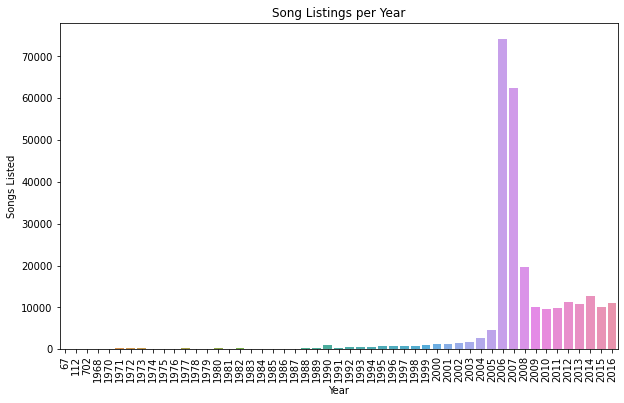

In [313]:
# get a count of rows listed for each year
year_counts = songs['year'].value_counts()

# visualize year counts
plt.figure(figsize=(10,6))
sns.barplot(y=year_counts.values, x=year_counts.index)
plt.xticks(rotation=90)
plt.xlabel(xlabel='Year')
plt.ylabel(ylabel='Songs Listed')
plt.title('Song Listings per Year')
plt.show()

A few things are apparent from this graph. First of all, the obvious spike in song listings from the year 2006 to 2008. Besides that spike, songs seem to steadily increase in number listed per year, but something interesting must have happened in that year. After doing a little bit of research, I discovered that that may have been due to an increase in the availability of music, as that time is when services like Spotify, TIDAL, and SoundCloud came out.

Another thing to notice is the odd lower outliers. Investigation may be required to understand those.

In [314]:
# display all songs published before the year 1960
songs.loc[songs['year'] < 1960]

,index,song,year,artist,genre,lyrics
27657,27657,star,702,clipse,Hip-Hop,You're my star\nIt's such a wonder how you shi...
69708,69708,anywhere-remix,112,dru-hill,Hip-Hop,"Here we are all alone\nYou and me, privacy\nAn..."
147914,147914,it-s-over-now-remix,112,g-dep,Hip-Hop,What is this?\nNumbers in your pocket\nI remem...
238541,238541,come-see-me-remix,112,black-rob,Hip-Hop,"Baby, you can come see me 'cause I need you he..."
315540,315540,let-s-lurk,67,giggs,Hip-Hop,Verse 1:\nStill pulling up on smoke\nSkeng in ...
335205,335205,i-can-t-believe,112,faith-evans,Pop,[Chorus]\nI can't believe that love has gone a...


After doing some research, there seems to be no rhyme or reason in the listed years for these songs. Therefore, they will be considered input error, and in a dataset of over 200,000 songs negligable to our dataset. Drop the rows.

In [315]:
# Eliminate year error songs
songs = songs.loc[songs['year'] >= 1960]
print('earliest song:', songs['year'].min())
print('latest song:', songs['year'].min())

earliest song: 1968
latest song: 1968


In [316]:
# current number of songs
len(songs)

266550

There are still far too many songs to realistically include in an NLP corpus with my resources. To further narrow the selection, as well as obtain the goal of generating more current-sounding hiphop lyrics, only the five recent years of songs will be considered. 

In [317]:
# Get the latest 5 unique years in the dataset
latest_years = sorted(songs['year'].unique())[-5:]
latest_years

[2012, 2013, 2014, 2015, 2016]

In [318]:
# Obtain the songs published within latest_years
latest_songs = songs.loc[songs['year'].isin(latest_years)]
latest_songs['year'].unique()

array([2013, 2012, 2016, 2015, 2014])

In [319]:
len(latest_songs)

56165

The dataframe has been reduced to 56,000+ songs, which is much better, but still too large for processing. Next, since again this is a rap-bot, not a pop-bot, elimination by genre will help.
#### Genre

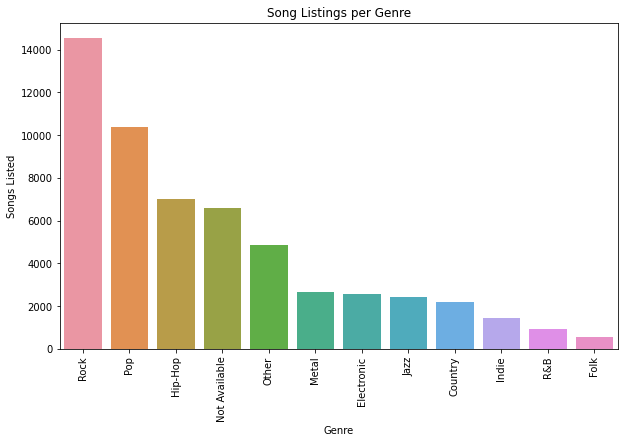

In [320]:
# Get number of rows listed for each genre
genre_counts = latest_songs['genre'].value_counts()

# visualize genre counts
plt.figure(figsize=(10,6))
sns.barplot(y=genre_counts.values, x=genre_counts.index)
plt.xticks(rotation=90)
plt.xlabel(xlabel='Genre')
plt.ylabel(ylabel='Songs Listed')
plt.title('Song Listings per Genre')
plt.show()

Hip-Hop is definitely going to be the genre of choice in  generating rap lyrics (since rap and hip hop are synonymous). Before eliminating the rest of the genres, however, the `Not Available` and `Other` genre, which is similar in size to the Hip-hop genre, is intriguing...

In [321]:
# Investigate 'Other' genre
latest_songs.loc[latest_songs['genre'] == 'Other'].head(5)

,index,song,year,artist,genre,lyrics
453,453,dimestore-wedding-ring,2016,dave-sterling,Other,"(A little thin band, her finger left hand)\nSh..."
468,468,acil-caara,2016,cenk-r-lr-etin,Other,"Sen arardÄ±n beni cep telefonumdan\nArardÄ±n,a..."
469,469,asla-vazgerngmem-senden,2016,cenk-r-lr-etin,Other,"devam et\nhadi bebek\ndevam et onu yapmaya,doÄ..."
470,470,ka-ra-k-kanatlar,2016,cenk-r-lr-etin,Other,bebek anlamalÄ±yÄ±m\nneden biz sadece birbirim...
471,471,asla-vazgerngme,2016,cenk-r-lr-etin,Other,SavaÅtÄ±ÄÄ±m Åu zalimler beni uyutmayacak\n...


In [322]:
# Investigate 'Not Available' genre
latest_songs.loc[latest_songs['genre'] == 'Not Available'].head(5)

,index,song,year,artist,genre,lyrics
427,427,la-doble-cara,2013,banda-carnaval,Not Available,Ahora me dices que te arrepientes\nTu de haber...
428,428,y-te-vas,2013,banda-carnaval,Not Available,"Hoy, me parto en dos\nDÃ³nde quedaron aquellas..."
429,429,lo-que-pienso-de-ti,2012,banda-carnaval,Not Available,Que bonito es saber que me quieres tanto como ...
433,433,a-ver-a-que-horas,2016,banda-carnaval,Not Available,A Ver A Que Horas se te antoja darte cuenta\nQ...
440,440,duo-desde-cuando-no-me-quieres,2016,banda-carnaval,Not Available,Amor\nDesde cuÃ¡ndo no me quieres\nHace cuÃ¡nt...


While the `Other` genre is very hard to pin down, the `Not Available` genre, at least in the first five records, appears to be spanish. Neither apply to the current project, since the generated lyrics are intended to be in English (which will be touched on later).

In [323]:
# Isolate hip-hop songs from latest songs
latest_hiphop = latest_songs[latest_songs['genre'] == 'Hip-Hop']
len(latest_hiphop)

7000

Now down to 7000 songs, the lyrics column will be used to justify further reducing
#### Lyrics
First, look for duplicated song lyrics

In [324]:
# Get duplicates
duplicated = latest_hiphop['lyrics'].duplicated()

# Get all songs and their duplicates
duplicated_lyrics = latest_hiphop.loc[duplicated, 'lyrics']
latest_hiphop.loc[latest_hiphop['lyrics'].isin(duplicated_lyrics)]

,index,song,year,artist,genre,lyrics
723,723,bduan-ck-dich-hoch,2012,deichkind,Hip-Hop,"Halt die Deadline ein, so ist's fein\nHol die ..."
728,728,bduan-ck-dich-hoch-deluxe-remix,2012,deichkind,Hip-Hop,"Halt die Deadline ein, so ist's fein\nHol die ..."
7789,7789,kids-again-zed-bias-remix,2014,example,Hip-Hop,We'll be whoever we wanna be\nWe'll laugh in t...
7790,7790,all-the-wrong-places-calyx-teebee-remix,2014,example,Hip-Hop,I don't know where we are\nBut can you bring m...
7791,7791,kids-again-dimension-remix,2014,example,Hip-Hop,We'll be whoever we wanna be\nWe'll laugh in t...
...,...,...,...,...,...,...
360987,360987,bring-it-all-home,2012,dappy,Hip-Hop,"We are , we are,\nWe are, we are the only ones..."
360991,360991,rockstar-bbc-live-lounge,2012,dappy,Hip-Hop,They say that I'm dangerous\nLike everything I...
360997,360997,rockstar,2012,dappy,Hip-Hop,They say that I'm dangerous\nLike everything I...
360998,360998,bring-it-home,2012,dappy,Hip-Hop,"We are , we are,\nWe are, we are the only ones..."


In [325]:
# print total number of duplicates
print('Duplicated Lyrics Count:', duplicated.sum())

Duplicated Lyrics Count: 578


It appears duplicates could be live vs recorded or covers. In any case, only one copy of each song's lyrics is desired for the training set.

In [0]:
# drop the duplicates from the dataframe
latest_hiphop.drop(duplicated_lyrics.index, inplace=True)

In [327]:
len(latest_hiphop)

6422

In [328]:
latest_hiphop.head()

,index,song,year,artist,genre,lyrics
333,333,boyz-n-the-hood,2015,eazy-e,Hip-Hop,"Hey yo man, remember that shit Eazy did a whil..."
334,334,luv-4-dem-gangsta-z-cookin-soul-remix,2015,eazy-e,Hip-Hop,"(Verse 1)\nAw shit, let's take a trip\nJust si..."
714,714,der-strahl,2012,deichkind,Hip-Hop,Komm steig in das Raumschiff\nWir bringen den ...
715,715,pferd-aus-glas,2012,deichkind,Hip-Hop,Ich checke meine Mail auf dem Segway\nWas sind...
716,716,partnerlook,2012,deichkind,Hip-Hop,"Ein Schritt vor, ein zurÃ¼ck\nDu und ich ganz ..."


Next, as is noticed above, it is obvious that multiple languages of lyrics are still in the dataset. As mentioned before, only english lyrics are intended to be produced by rap-bot, so only english songs are necessary for training. To determine the language of each song, a fantastic python package called [langdetect](https://pypi.org/project/langdetect/) by Nakatani Shuyo, will be used to determine the language of each song.

In [0]:
try:
  import langdetect
except:
  !pip install langdetect --quiet
  import langdetect

In [0]:
# Define a function to detect the language of each song
def detect_language(string):
  try:
    # use langdetect library to return a two letter
    # indication of the text language
    return langdetect.detect(string)
  except:
    # if no language can be determined, return none
    return 'none'

In [331]:
# apply the language detect function to all of the rows in the data
latest_hiphop['language'] = latest_hiphop['lyrics'].apply(detect_language)
latest_hiphop.head()

,index,song,year,artist,genre,lyrics,language
333,333,boyz-n-the-hood,2015,eazy-e,Hip-Hop,"Hey yo man, remember that shit Eazy did a whil...",en
334,334,luv-4-dem-gangsta-z-cookin-soul-remix,2015,eazy-e,Hip-Hop,"(Verse 1)\nAw shit, let's take a trip\nJust si...",en
714,714,der-strahl,2012,deichkind,Hip-Hop,Komm steig in das Raumschiff\nWir bringen den ...,de
715,715,pferd-aus-glas,2012,deichkind,Hip-Hop,Ich checke meine Mail auf dem Segway\nWas sind...,de
716,716,partnerlook,2012,deichkind,Hip-Hop,"Ein Schritt vor, ein zurÃ¼ck\nDu und ich ganz ...",de


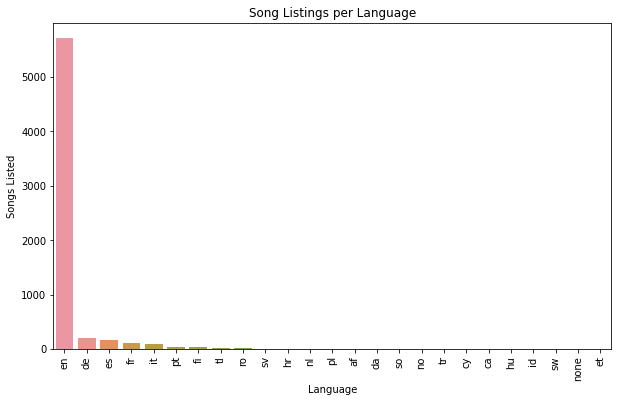

In [332]:
# Get number of rows listed for each language
lang_counts = latest_hiphop['language'].value_counts()

# visualize language counts
plt.figure(figsize=(10,6))
sns.barplot(y=lang_counts.values, x=lang_counts.index)
plt.xticks(rotation=90)
plt.xlabel(xlabel='Language')
plt.ylabel(ylabel='Songs Listed')
plt.title('Song Listings per Language')
plt.show()

Fortunately the overwhelming majority of songs are in the enlish language. Only select those songs...

In [333]:
# Isolate hiphop songs in dataframe with english lyrics
latest_hiphop_en = latest_hiphop.loc[latest_hiphop['language'] == 'en']
len(latest_hiphop_en)

5712

Now down to 5716 songs, the desired segment of the dataset has been isolated. More rows could be dropped during the outliers stage, but this is a good idea of how large the corpus will be.
#### Outliers

Each song is a series of lines separated by the `\n` character. To ensure this is consistent throughout the dataset, lines will be counted, and the average character length of each line in each song will also be counted, with the intention of providing insight into any outliers that may exist.

In [0]:
# get the number of lines in each song
latest_hiphop_en['num_lines'] = latest_hiphop_en['lyrics'].str.split('\n').apply(len)
# get the avg lenght of lines in each song
latest_hiphop_en['avg_line_len'] = latest_hiphop_en['lyrics'].apply(len) / latest_hiphop_en['num_lines']

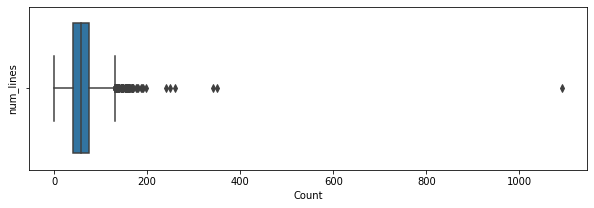

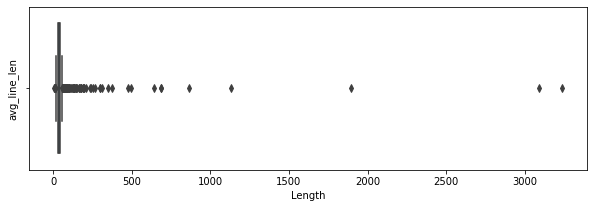

In [335]:
# Visualize two boxplots, one for num_lines and the other for avg_line_len
plt.figure(figsize=(10,3))
sns.boxplot(latest_hiphop_en['num_lines'])
plt.ylabel(ylabel='num_lines')
plt.xlabel(xlabel='Count')
plt.show()
plt.figure(figsize=(10,3))
sns.boxplot(latest_hiphop_en['avg_line_len'])
plt.ylabel(ylabel='avg_line_len')
plt.xlabel(xlabel='Length')
plt.show()

The above boxplots illustrate a great many outliers, which in many cases is not a bad thing. However, it is necessary to handle. For `num_lines`, it is reasonable to assume some songs are far longer than other songs, but a song with over 1000 bars may be a bit much. That will be investigated and possibly dropped.

For `avg_line_len`, high values may mean something more detrimental, like a lack or inconsistency of the `\n` character. Those will also be investigated.

In [336]:
# Locate major outliers to the number of lines in each song
num_line_outliers = latest_hiphop_en.loc[latest_hiphop_en['num_lines'] > latest_hiphop_en['num_lines'].quantile(.99)]
num_line_outliers

,index,song,year,artist,genre,lyrics,language,num_lines,avg_line_len
18869,18869,rap-monument,2014,flatbush-zombies,Hip-Hop,RAPROCK LIT POP NEWS COUNTRY R&B; HISTORY SPOR...,en,1091,38.617782
21878,21878,deep-sea-diver,2013,angel-haze,Hip-Hop,Rage colored lilies\nBrave covered in pity\nLi...,en,140,30.592857
39888,39888,yao-ming-remix,2012,david-banner,Hip-Hop,[Verse 1 - Chris Brown]\nIm a king yes Im a di...,en,154,21.655844
40885,40885,independent-living,2012,dizzy-wright,Hip-Hop,Uh\nIt's too easy...\nI'm doin' good I don't n...,en,147,37.095238
42770,42770,bottles-and-rockin-j-s-remix,2012,game,Hip-Hop,"[Dj Khaled]\nAyo Game, what they do boy\nIt's ...",en,167,32.586826
43005,43005,hit-em-hard,2014,game,Hip-Hop,I got a black mac and a six pack\nI don't work...,en,140,34.585714
50813,50813,murals-changes,2016,berner,Hip-Hop,[Murals]\n[Hook: Berner]\n(Life)\nI live for m...,en,169,35.751479
51164,51164,free-meal-horseshoe-gang-diss,2015,funk-volume,Hip-Hop,[Intro: Hopsin]\nHorseshit Gang is amateurs\nF...,en,161,47.055901
56664,56664,everybody,2013,dave-east,Hip-Hop,"That's what everybody say, that's what everybo...",en,149,38.872483
69457,69457,lotta-that,2014,g-eazy,Hip-Hop,Talking 'bout whiskey bottles\n(Gotta lotta lo...,en,152,35.703947


In [337]:
# Locate major outliers to the average length of each line in each song
avg_line_len_outliers = latest_hiphop_en.loc[latest_hiphop_en['avg_line_len'] > latest_hiphop_en['avg_line_len'].quantile(.99)]
avg_line_len_outliers

,index,song,year,artist,genre,lyrics,language,num_lines,avg_line_len
16435,16435,pncintlofwgkta-faturing-tyler-the-creator-domo...,2012,casey-veggies,Hip-Hop,i lock this house this is my electronic via fr...,en,1,130.000000
21897,21897,live-it-up-practice,2012,angel-haze,Hip-Hop,Verse1\tHeart Broken too often love wasted no ...,en,1,3093.000000
27131,27131,broken-glass,2012,grandmaster-flash,Hip-Hop,Broken glass everywhere dont push me cuz am cl...,en,1,91.000000
27934,27934,lies,2012,big-l,Hip-Hop,Contradiction is a word you no to well dont lo...,en,1,126.000000
30545,30545,wowzers-freestyle,2013,fat-trel,Hip-Hop,My dick a bazooka my house aint a safe my dick...,en,2,1129.500000
42775,42775,god-speed,2012,game,Hip-Hop,"When you hear that sound, you already know wha...",en,47,91.361702
42783,42783,i-don-t-like,2012,game,Hip-Hop,"The Game ft. Kanye West, Pusha T, Chief Keef, ...",en,1,80.000000
50783,50783,shut-up,2012,berner,Hip-Hop,Shut Up x4\nAll that talking ain't making no b...,en,17,171.941176
51163,51163,fv-2013,2013,funk-volume,Hip-Hop,Hook:\nFinna throw the whole game outta focus ...,en,15,313.666667
54313,54313,in-the-ghetto,2012,e-40,Hip-Hop,(E40) GHE TTO pissed stained mattress on the f...,en,1,867.000000


The investigation certainly revealed some weird instances. Take fore example, `childish-gamibino`'s `because-the-internt-screenplay-part-3`. As odd as these are, and with the time contraint of this project, the course of action here is to drop the outlying rows.

In [338]:
# merge outliers together to create a drop mask
outliers = num_line_outliers.merge(avg_line_len_outliers, how='outer')


# drop outliers from dataset
latest_hiphop_en.drop(outliers['index'], axis=0, inplace=True)

len(latest_hiphop_en)

5599

In [339]:
latest_hiphop_en.describe()

,index,year,num_lines,avg_line_len
count,5599.000000,5599.00000,5599.000000,5599.000000
mean,177783.014645,2013.87980,58.004644,38.007544
std,104887.811420,1.48928,26.810257,8.324248
min,333.000000,2012.00000,1.000000,9.266667
25%,98904.500000,2012.00000,41.000000,32.493420
50%,170107.000000,2014.00000,57.000000,38.135135
75%,258844.500000,2015.00000,75.000000,43.403125
max,362156.000000,2016.00000,138.000000,76.000000


The verdict is in! The rap-bots dataframe containing the cleaned dataset is 5603 songs long, each released between 2012 and 2016, with an average number of 58 bars per song and 36 characters per line.

### Processing

#### Regex
The first thing to do in the processing step is remove instances of Verse/Chorus, etc and replace the `/t` characters with spaces. Given more time, a much more in depth processing effort would be made, but since the deadline is so soon, this will be the extent of the pre-spacy processing.

In [0]:
# Use regex to clean line/chorus/verse indicators from lyrics
latest_hiphop_en['lyrics'] = latest_hiphop_en['lyrics'].str.replace('\([^)]*\)|\[[^]]*\]|\{[^]]*\}|Verse|Chorus|Intro', '', regex=True)
# Replace '\t' char with ' '
latest_hiphop_en['lyrics'] = latest_hiphop_en['lyrics'].str.replace('\t', ' ')

#### Spacy
The NLP library I want to use to clean the dataset is the Spacy model, which has production-level speeds and capabilities.

In [341]:
import spacy
!python -m spacy download en_core_web_sm --quiet
nlp = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Now to define the processing function. The first thing I want to do is take advantage of Spacy's processing to rid each song of punctuation, numbers, and empty strings. The second thing rap bot needs as far as processing goes is a little funny and requires some extra explanation.

### Reverse the input!

Two major, unique challenges present themselves in the generation of rap lyrics: rhyming and syllables. While both will be handled in the generation side, each will rhyming does demand specific processing steps. The traditional structure of a rap contains bars of text that END with words that rhyme with words in the next line. To ensure that the rhymes exist, one could naturally presume that they want to be chosen manually and fed to the model to generate the rest of the lines, but how does one get earlier output in a sentence from later input? Don't NLP models work the other way around?

Flip the sentences around. The RNN model to be used only knows english because it is trained to understand relationships with its inputs. **If it is trained to understand english backwards, it will return english backwards.** Then a simple function can reverse the output to be readable by humans again!

In [0]:
# define a function that will process songs
# with spacy, then reverse them on the word
# level
def process_rev_word(song):
# Split song by newline
  lines = song.split('\n')
  rev_bars = ''
  for line in lines:
    # Process line
    spacy_line = nlp(line)
    # Clean out punctuatin and numbers
    rev_line = ' '.join([token.text.lower() for token in spacy_line
                if not token.is_punct
                and token.pos_ != 'NUM'
                and token.text != ''][::-1])
    # Reverse each line and join it to the beginning
    # of the rest of the song
    rev_bars = '\n'.join([rev_line, rev_bars])
  return rev_bars

In [343]:
# acquire a test song
song_1 = latest_hiphop_en.iloc[1]['lyrics']
# display the song in its pre-processed state
song_1

"\nAw shit, let's take a trip\nJust sit back and light a spliff to this and don't step\nOn a funky-ass track jump back\nStrapped with a gat and a sack and a 7-8 flak\nCome clean, gangsta lean, I got green\nBut I serve dubs like it ain't no thing\nI hang with OG niggas don't set trip\nOr you might get a slug in your fuckin back\nI don't slack when it come to street\nI kick real g shit to a gangsta beat\nIt's so sweet, when you got money to spend\nI got a cool-ass tilt and a fly-ass Benz\nI make ends, spend my dough on no ho\nThat's how it is, nad that's how it goes\nAct like ya know when I creep real slow\nGivin love to them niggas that I know is real g's\n\nIf you got love for them gangstas\nLet me hear you one time if you down for the crime \nIf you got love for them hustlas\nLet me hear you say hooo if you makin straight dough \nIf you got love for them playas\nlet me hear you say ooooh, ladies we want you \nIf you got love for them straight g's\nLet me hear you motherfuckers just sc

In [344]:
# display the processed song
process_rev_word(song_1)

"  scream just motherfuckers you hear me let\n's g straight them for love got you if\nyou want we ladies ooooh say you hear me let\nplayas them for love got you if\ndough straight makin you if hooo say you hear me let\nhustlas them for love got you if\ncrime the for down you if time you hear me let\ngangstas them for love got you if\n\nya to love gives i but is it how 's that\nho no to dough my gives trip n't do i\ndick this suck you if time it hit me let\nbitch skanless a about fuck a gives i\nloco just 'm i cause so think n't do i but\ncrazy 'm i say hos me see n't ca bitches\neazy named nigga nut a bust dick long the 'm i cause\nme to come it when is it how 's that\nhurt get nobody move nobody\nwork do i fool dirt the to straight\nya rush to quick so thugsta hop hip\ns and g s and p i are see og that\nstreet compton a on bumpin shit my hear can i so\nbeat gangsta a of sound the to leapfrog i\nhog up straight a dog a be and cat the chase\ni must why z a e\n\nscream just motherfuckers

The processing words as expected, completely reversing a song. This means songs will be fed to the model from end to finish, word by word, and produced by the model in the same fashion.

In [0]:
# processs the dataframe
latest_hiphop_en['processed_rev_word'] = latest_hiphop_en['lyrics'].apply(process_rev_word)

In [0]:
latest_hiphop_en.head(5)

#### Save processed data
Now that that is done, the processed data will be saved to a local folder to allow it to be accessible again without having to repeat the cleaning process


In [0]:
latest_hiphop_en.to_csv(CSV_PROCESSED_PATH, index=False, encoding='utf-8')

## Training
With processed data, the rap bot model is ready to be defined and trained.

### Vectorizing and Sequentializing
Before training the model, the text data must be turned into something a machine can understand

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [76]:
# Read input from storage
CSV_PROCESSED_PATH = '/content/drive/My Drive/Thinkful/nlp/data/380000-lyrics-from-metrolyrics/lyrics_input.csv'
raps = pd.read_csv(CSV_PROCESSED_PATH)
raps.head()

,index,song,year,artist,genre,lyrics,language,num_lines,avg_line_len,processed_rev_word
0,333,boyz-n-the-hood,2015,eazy-e,Hip-Hop,"Hey yo man, remember that shit Eazy did a whil...",en,98,40.826531,shit sayin n't ai i cuz boy me quote n't do\nl...
1,334,luv-4-dem-gangsta-z-cookin-soul-remix,2015,eazy-e,Hip-Hop,"\nAw shit, let's take a trip\nJust sit back an...",en,83,40.132530,scream just motherfuckers you hear me let\n'...
2,2510,whole-thang,2012,2win,Hip-Hop,2Win Ft. 2 Chainz & Young Jeezy - Whole Thang\...,en,2,45.500000,thang whole jeezy young chainz ft\nthang whole...
3,2811,one-in-a-million,2013,down-with-webster,Hip-Hop,"I'm feeling like I'm one in a million,\nI'm th...",en,49,38.938776,a in 'm i like feeling 'm i\n\n\na in 'm i lik...
4,2812,chills,2013,down-with-webster,Hip-Hop,"I fell, like soldiers on the front line.\nUnde...",en,51,38.725490,you from came they\ncold the from come n't did...


#### One big rap
The input will be trained word by word to understand how raps function. Like a book could be fed in character by character, even though it could be split by chapters, so will the data be fed in, word by word, while it could be separable by song. In other words, the input data will be a concatenated sample of raps.


In [0]:
# concatenate a sample of raps into an 
# input rap
SAMPLE_SIZE = 300
train_input = raps.sample(SAMPLE_SIZE)['processed_rev_word'].sum()

In [78]:
# Determine number of words in corpus
num_words = len(train_input.split())
print('Number of words:', num_words)

Number of words: 131650


In [79]:
# Create the vocabulary and determine the
# length of that
vocab = sorted(set(train_input.split()))
vocab_len = len(vocab)
print('Number of unique words:', vocab_len)

Number of unique words: 9727


#### Vectorize the text
Before training, the rap needs to be mapped to numerical representation. Since we are doing this from a word-to-word level, each unique word will have its own numerical representation. Much of this training strategy was modified from a char-by-char model from [this TensorFlow tutorial](https://www.tensorflow.org/tutorials/text/text_generation)

In [0]:
# Create a mapping from unique words to indices
word2idx = {u:i for i, u in enumerate(vocab)}
# Create a mapping from indices to unique words
idx2word = np.array(vocab)

# map input to array of integers
text_as_int = np.array([word2idx[c] for c in train_input.split()])

In [81]:
# Show how the first 5 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(train_input.split()[:5]), text_as_int[:13]))

['that', 'like', 'dance', 'to', 'want'] ---- characters mapped to int ---- > [8630 4965 2174 8768 9320 4247 5960 8630 4965 2174 8768 9320 4247]


#### Create Training Dataset
The RNN model to be used takes in a sequence of words and predicts what the next most probable word will be. But right now, the input data `text_as_int` is simply a long string of numerical words. How can one turn that into sequences to train the model on with prdiction labels (since this is of course a **supervised learning** model)? Tensorflow provides a wonderful `tf.data.Dataset.from_tensor_slices` function to automate just that.


In [82]:
# The maximum length sentence we want for a single input in characters
seq_length = 8
examples_per_epoch = len(train_input.split())//(seq_length+1)

# Create training examples / targets
word_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

# preview 5 examples of values in dataset
for i in word_dataset.take(5):
  print(idx2word[i.numpy()])

that
like
dance
to
want


Now the `batch` method converts data values in `word_dataset` to sequences of the desired size.

In [83]:
# Create sequences from the dataset using the 
# batch method
sequences = word_dataset.batch(seq_length+1, drop_remainder=True)

# view a few sequences
for item in sequences.take(5):
  print(repr(' '.join(idx2word[item.numpy()])))

'that like dance to want i oooh that like'
'dance to want i last time night that make'
"'s let past stumbling me got you back memory"
'my need i roll the on stomach my feel'
'i control outta me got you control outta me'


For each sequence, create input-output variables but shifting each sequence by one. Those input-output sequences are what will go in the input dataset

In [84]:
# Define a function that takes in a sequence and turns
# it into input-output sequence pairs
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

# Fill dataset with input-output sequences
dataset = sequences.map(split_input_target)

# Print example input and output string
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(' '.join(idx2word[input_example.numpy()])))
  print ('Target data:', repr(' '.join(idx2word[target_example.numpy()])))
dataset

Input data:  'that like dance to want i oooh that'
Target data: 'like dance to want i oooh that like'


<MapDataset shapes: ((8,), (8,)), types: (tf.int64, tf.int64)>

In these vectors, each index is a time step. So at time step 0, the input 'man' will predict the output 'better' (which will eventually be reversed after generation, and be read "better man"). Since the model is RNN, it will consider the previous step in its prediction.

In [85]:
# Print an example of how the model predicts the next word
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2word[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2word[target_idx])))

Step    0
  input: 8630 ('that')
  expected output: 4965 ('like')
Step    1
  input: 4965 ('like')
  expected output: 2174 ('dance')
Step    2
  input: 2174 ('dance')
  expected output: 8768 ('to')
Step    3
  input: 8768 ('to')
  expected output: 9320 ('want')
Step    4
  input: 9320 ('want')
  expected output: 4247 ('i')


#### Create Training Batches
Use the `tf.data` method to split text into manageable sequences. Then use the `.shuffle` method to shuffle the data around in batches

In [86]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 8), (64, 8)), types: (tf.int64, tf.int64)>

### Build the Model
Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define the model:

* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.GRU`: A type of RNN with size `units=rnn_units` (can also use a LSTM layer here, will be testing both)
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

#### Model Definition

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [0]:
# Define a function to build a model
def build_model(vocab_size, embedding_dim, rnn_units, batch_size, rnn_type='gru'):
  # define the sequential model type
  model = tf.keras.Sequential()
  # Input layer -> embedding
  
  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim,
                            batch_input_shape=[batch_size, None]))
  # GRU layer -> This is the RNN part of the model
  if rnn_type == 'gru':
    model.add(tf.keras.layers.GRU(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'))
  elif rnn_type == 'lstm':
    model.add(tf.keras.layers.LSTM(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'))
  else:
    raise KeyError('rnn_type', rnn_type, 'not acceptable. Must be \'gru\' or\'lstm\'')
  # Output layer -> Dense layer at size of vocab
  # predicts the next word each iteration.
  model.add(tf.keras.layers.Dense(vocab_size))

  # return built model
  return model

In [0]:
# Build the model
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

For each word the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate predictions for the log-likelihood of the next word.

This image comes from the same tensorflow tutorial, and shows an example of a character-by-character model. The same thought applies to this model, but replace chars with words.

![GRU Example Model](https://www.tensorflow.org/tutorials/text/images/text_generation_training.png)

Now that the model is generated, ensure that the model will behave correctly. 

In [90]:
# Generate an example prediction on an untrained model
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  # Check the shape of the dataset
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 8, 9727) # (batch_size, sequence_length, vocab_size)


Note that while the input length is `8` above, any size input can be used (Including, hypothetically, one word that rhymes with another word).

In [91]:
# Preview the untrained model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (64, None, 256)           2490112   
_________________________________________________________________
gru_4 (GRU)                  (64, None, 1024)          3938304   
_________________________________________________________________
dense_6 (Dense)              (64, None, 9727)          9970175   
Total params: 16,398,591
Trainable params: 16,398,591
Non-trainable params: 0
_________________________________________________________________


### Train the Model
Now that the model has been defined, it is time to compile it and train it on the dataset.

#### Loss Function
For any deep learnign model to work, it has to optimize for the least loss. The loss function to be used for this is a specific version of the `categorical_crossentropy` function from TensorFlow. 

In [92]:
# Define the loss function (specify from_logits = true)
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# Print an example of a calculated loss using
# the specified function
example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 8, 9727)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       9.182534


#### Optimizer
For this model, the adam optimizer and the rmsprop optimizers will be used. both are proven optimizers, and choosing between them is a matter of hyperparameter tuning

In [0]:
model.compile(optimizer='adam', loss=loss)

In [0]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### Execute Training
Set Epoch and fit the model with the dataset, epochs

In [0]:
EPOCHS = 20

In [96]:
# Train model and save training data in the history variable
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
228/228 [==============================] - 7s 31ms/step - loss: 6.3321
Epoch 2/20
228/228 [==============================] - 7s 31ms/step - loss: 5.4192
Epoch 3/20
228/228 [==============================] - 7s 30ms/step - loss: 4.8798
Epoch 4/20
228/228 [==============================] - 7s 31ms/step - loss: 4.3278
Epoch 5/20
228/228 [==============================] - 7s 31ms/step - loss: 3.7799
Epoch 6/20
228/228 [==============================] - 7s 31ms/step - loss: 3.2943
Epoch 7/20
228/228 [==============================] - 7s 31ms/step - loss: 2.8908
Epoch 8/20
228/228 [==============================] - 7s 32ms/step - loss: 2.5607
Epoch 9/20
228/228 [==============================] - 7s 31ms/step - loss: 2.2918
Epoch 10/20
228/228 [==============================] - 7s 30ms/step - loss: 2.0684
Epoch 11/20
228/228 [==============================] - 7s 31ms/step - loss: 1.9008
Epoch 12/20
228/228 [==============================] - 7s 30ms/step - loss: 1.7493
Epoch 13/20
2

In [97]:
history.history

{'loss': [6.332096576690674,
  5.419155597686768,
  4.8797502517700195,
  4.327816486358643,
  3.779920816421509,
  3.294306993484497,
  2.8908402919769287,
  2.5606842041015625,
  2.291783571243286,
  2.0684120655059814,
  1.9008183479309082,
  1.749255895614624,
  1.6408991813659668,
  1.5506528615951538,
  1.4780288934707642,
  1.410888671875,
  1.3704454898834229,
  1.3249448537826538,
  1.2935116291046143,
  1.2627800703048706]}

## Text Generation
Time for RapBot to *spit bars*


### Restore last checkpoint
To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different batch_size, model needs to be rebuilt and weights restored from the checkpoint.

In [98]:
# restore last checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_20'

In [0]:
# Rebuild model from checkpoint weights but with only
# batchsize = 1
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

In [100]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, None, 256)            2490112   
_________________________________________________________________
gru_5 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_7 (Dense)              (1, None, 9727)           9970175   
Total params: 16,398,591
Trainable params: 16,398,591
Non-trainable params: 0
_________________________________________________________________


### Define Prediction Loop
![To generate text the model's output is fed back to the input](https://www.tensorflow.org/tutorials/text/images/text_generation_sampling.png)
For each bar:
>- Start by choosing a start string, initializing the RNN state and setting the syllable range you want each bar to be within.
>- Get prediction distribution of next word using the start string and RNN state
>- Then use a categorical distribution to calculate the index of the predicted word, and use that word as the next input
>- The RNN state returned by the model is fed back into the model so that it now has more context than just the subsequent inputs.
>
>Then once that is done:

- Find a word in the vocabulary that rhymes with the word you started with and repeat the process for a second bar
- Group the two bars together, one right after the other. Note that at this point, they are still backwards, as in the start word is the last word in the song and the rhyme is the last word in the second to last line. 
- While the generated text is still backwards, grab the last word and use it as the starting string to simply predict one word: the next rhyme. This makes it so there is at least some coherence from rhyming pair to rhyming pair, even though there isn't much between the rhyming pair
-Repeat the whole process until the desired number of bars is reached




#### Syllables
To obtain syllable counts from words, the `phoneme-groups-with-syllables` json dataset found on `docmarionum1`'s github will serve as the dictionary of words. When a word isn't found, the quick solution (again owed to the time constraint) is to round the division of the length of a word to the nearest whole number.

In [0]:
# define the url from which to obtain the 
# phoneme dictionary json object
phoneme_url = 'https://raw.githubusercontent.com/docmarionum1/haiku/master/phoneme-groups-with-syllables.json'

In [0]:
import requests
import json
import random
import re

In [0]:
# Define an empty dict called dictionary
dictionary = {}
# Get the poneme dictionary response
f = requests.get(phoneme_url)
# Parse through the lines in the response text
for l in f.text.split('\n'):
  # Ignore empty lines
  if l == '':
    continue
  # Otherwise, convert the json string to a dict
  j = json.loads(l)
  # append the keyword and syllable count for each word
  # to the dictionary (ignoring uncommon single letter words)
  if len(j['word']) > 1 or j['word'] in ['A', 'I', 'O']:
    dictionary[j['word']] = len(j['syllables'])

# Create a pandas dataframe out of the dictionary
dict_df = pd.DataFrame.from_records([(k, dictionary[k]) for k in dictionary])
# Limit the dataframe by words with <= 7 syllables
dict_df = dict_df[dict_df[1] <= 7]

In [104]:
# Preview a random sample of the syllables df
dict_df.sample(5)

,0,1
94442,PRIVATES,2
124085,UNISYS',3
27835,DAHLE,2
112806,SPINDLER,3
48065,GLOBULAR,3


In [105]:
# define a function to get syllables for any sentence
def get_syllables(sent, sylls_df=dict_df):
  # split the sentence into words
  words = sent.split()
  # initialize the count variable
  syllables = 0
  # iterate through each word
  for word in words:
    # convert string to uppercased key-form
    syl_key = ''.join(re.findall('[A-z]', word)).upper()
    # get the syllable value at that key
    sylls = sylls_df.loc[sylls_df[0] == syl_key][1].values
    # If syllables found
    if len(sylls) > 0:
      # evaluate the syllable (stored in list)
      num = sylls[0]
    # word not found case
    else:
      # Avg word syllable length is 3, so divide word
      # length by 3 and round to nearest whold number
      num = int(len(word) / 3 + .5)
    # increment total syllable count
    syllables += num
  return syllables

# preview example
print('ridiculous', get_syllables('ridiculous'))
print('rap bot', get_syllables('rap bot'))

ridiculous 4
rap bot 2


#### Rhymes
To accomplish rhyming for this project, jameswenzel's [Phyme](https://github.com/jameswenzel/Phyme) dictionary for song lyrics is very helpful. Using it, one can generate 'slant rhymes' (`help` with `belt`) or exact rhymes (`rhyme` with `time`). Both slant and exact rhymes are found for the start word, then compared with the vocabulary. The randomly selected first word that is found in both is used as the rhyme to go. 

In [0]:
!pip install phyme --quiet
from Phyme import Phyme
ph = Phyme()

When one of the `get_something_rhyme` methods are called, a dictionary is returned, organizing each rhyme by the amount of syllables in each. At this stage, the syllable count doesn't matter as much, each will need to be concatted into one large list.

In [0]:
# Define a function that returns a list of rhymes
# that exist in a given vocabulary
def get_rhymes(word, vocabulary=vocab):
  rhymes = []
  # Handle empty input
  if word == '':
    return rhymes
  try:
    # Get slant rhymes
    fam_rhymes = ph.get_family_rhymes(word)
    # For each syllable count
    for key in fam_rhymes:
      # Parse through rhymes and add matches to 
      # big rhymes list
      rhymes += [re.sub('\([0-9]\)','', r) for r in fam_rhymes[key] if r not in rhymes 
                                                                        and r in vocab 
                                                                        and len(r)> 1
                                                                        and r != word]
    # Same but for perfect rhymes
    perf_rhymes = ph.get_perfect_rhymes(word)
    for key in perf_rhymes:
      rhymes += [re.sub('\([0-9]\)','', r) for r in perf_rhymes[key] if r not in rhymes 
                                                                        and r in vocab 
                                                                        and len(r) > 1
                                                                        and r != word]  
    return rhymes
  # If there is an error querying rhyme with word
  except KeyError:
    return rhymes

In [108]:
get_rhymes('time')

['mine',
 'crime',
 'fine',
 'grime',
 'shine',
 'line',
 'rhyme',
 'prime',
 'whine',
 'pine',
 'lime',
 'dine',
 'wine',
 'sign',
 'climb',
 'nine',
 'shyne',
 'dime',
 'recline',
 'design',
 'define',
 'decline',
 'aline',
 'supine',
 'redefine']

#### Generate Lyrics
This is where the indented part of the prediction loop definition above comes into play. This is the per-line text generation function.

In [0]:
# Define a function to ensure the first user
# input word is in the corpus
def ensure_input(start_sent, vocab=vocab):
  usable = True
  for word in start_sent.split():
    if word not in vocab:
      print(word.upper(), 'not in vocabulary. Try another start word')
      usable = False
  return usable

In [110]:
# Define the function that generates the next
# word in the sequence
def generate_word(model, start_sent, temperature=1.0, vocab=vocab):
   # evaluate start string to numbers (vectorizing)
  input_eval = [word2idx[w] for w in start_sent.split()]
  input_eval = tf.expand_dims(input_eval, 0)

  # Here batch size == 1
  model.reset_states()

  # make predictions
  predictions = model(input_eval)

  # remove the batch dimension
  predictions = tf.squeeze(predictions, 0)

  # using a categorical distribution to predict the 
  # word returned by the model
  predictions = predictions / temperature
  predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

  # get the string form of the predicted word
  predicted_word = idx2word[predicted_id]

  return predicted_word

generate_word(model, 'hey')

'cabeza'

In [0]:
def generate_line(model, start_sent, sylls_range=(8,14), sub_sent = '', sylls_df=dict_df, temperature=1.0, vocab=vocab):
  # Generate text using the learned model
  
  # initialize a max_sylls variable for the line
  # it is a random int within sylls_range
  max_sylls = random.randint(*sylls_range)
  # get total current number of syllables so far
  # subtract syllables for subsent (used to augment
  # prediction cohesiveness, but not intended to be
  # in the model)
  curr_sylls = get_syllables(start_sent, sylls_df) - get_syllables(sub_sent, sylls_df)
  
  # empty list to store results
  text_generated = []

  # evaluate start string to numbers (vectorizing)
  input_eval = [word2idx[w] for w in start_sent.split()]
  input_eval = tf.expand_dims(input_eval, 0)

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = temperature

  # Here batch size == 1
  model.reset_states()
  # While the text to be generated has less than
  # the desired amount of syllables
  while curr_sylls < max_sylls:
    # make predictions
    predictions = model(input_eval)

    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the 
    # word returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # We pass the predicted character as the next input to the model
    # along with the previous hidden state
    input_eval = tf.expand_dims([predicted_id], 0)

    # get the string form of the predicted word
    predicted_word = idx2word[predicted_id]

    #increment curr_sylls by the predicted word's sylls
    curr_sylls += get_syllables(predicted_word)

    # append predicted word to generated text
    text_generated.append(predicted_word)
  
  # remove sub_sent from start_sent
  start_word = start_sent.replace(sub_sent, '').strip()

  # add the start sent to the predicted words
  return ' '.join([start_word, ' '.join(text_generated)])

In [112]:
# Test it out
print(ensure_input('corpus'))
print(ensure_input('next'))
print(generate_line(model, 'next'))

CORPUS not in vocabulary. Try another start word
False
True
next tony nigga want i whenever but you


#### Generate Rhyming Lines
Now that lines can be generated, a function must be defined that generates two or more rhyming lines

In [113]:
def make_rhyming_lines(model, start_sent, sylls_range=(8,14), num_rhyme_lines=2, sub_sent='', sylls_df=dict_df, temperature=1.0, vocab=vocab):
  # initialize a list to store each rhyming line in
  lines = []
  # given the first start and sub_sent, make the first line
  sent = generate_line(model, start_sent, sylls_range, sub_sent, sylls_df, temperature, vocab)
  lines.append(sent)

  # remove the sub_sent from the start_word
  start_word = start_sent.replace(sub_sent, '').strip()
  # get a randomized list of rhymes for the start word
  rhymes = get_rhymes(start_word, vocab)
  random.shuffle(rhymes)

  # While the number of generated lines is less than 
  # the max number of rhyming lines inputed
  # and while there are still unvisited rhymes left
  while len(lines) < num_rhyme_lines and len(rhymes) > 0:
    # set a sub_sentence from the previous line
    curr_sub_sent = lines[len(lines)-1]
    # pop a rhyme from the randomized list
    r = rhymes.pop()
    # join the rhyme and sub_sentence -> get more context
    curr_start_sent = ' '.join([r, curr_sub_sent])
    # generate a line with the context of the previous line
    # and the current input of the rhyming word
    sent = generate_line(model, curr_start_sent, sylls_range, curr_sub_sent, sylls_df, temperature, vocab)
    # append the generated line to the lines
    lines.append(sent)

  return lines

rev_bars = '\n'.join(make_rhyming_lines(model, 'think'))
print(rev_bars)

think others us let to used i girl white lil the
rethink for myself do 'll i know hulksters


#### Generate Song
Now that rhyming lines can be generated, a function must be defined that generates two or more rhyming lines, then more groups of rhyming lines, until the total number of lines adds up to the user specified number of total lines.

In [114]:
def make_song(model, start_sent, sylls_range=(8,14), num_rhyme_lines=2, num_total_lines=4, sub_sent='', sylls_df=dict_df, temperature=1.0, vocab=vocab):
  # initialize an empty list of total lines
  total_lines = []
  
  # generate the first rhyming group
  rhyme_group = make_rhyming_lines(model, start_sent, sylls_range, num_rhyme_lines, sub_sent, sylls_df, temperature, vocab)
  total_lines += rhyme_group

  while len(total_lines) < num_total_lines:
    # set the sub sentence to the previous line
    curr_sub_sent = total_lines[len(total_lines)-1]
    # get a start word using the sub sentence
    start_word = generate_word(model, curr_sub_sent, temperature, vocab)
    # join start word and sub_sent together -> get more context
    curr_start_sent = ' '.join([start_word, curr_sub_sent])
    # generate a rhyming group with the context of the previous line
    # and the current input of the start word
    rhyme_group = make_rhyming_lines(model, curr_start_sent, sylls_range, num_rhyme_lines, curr_sub_sent, sylls_df, temperature, vocab)
    # append the generated rhyming group to the lines
    total_lines += rhyme_group

  return '\n'.join(total_lines)

make_song(model, 'think')

"think i nigga dying worth was it hope i shit\nclink that dawg my eyes your open he girl some need i\npart course my all brainless going 's she\nsmart up way my dig to want i hell"

#### Reverse Functions
Since the model spits out reverse lines, sentences and songs ought to be reversed back to human readable text eventually

In [0]:
# Define a function to reverse sentences
def reverse_sentence(sentence):
  return ' '.join(sentence.split(' ')[::-1])

# Define a function to reverse a song
def reverse_song(song):
  fw_lines = ''
  # split song into lines
  lines = song.split('\n')
  # iterate through lines from end to beginning
  for line in lines[::-1]:
    # reverse each line
    fw_line = reverse_sentence(line)
    # append the lines to the fw_lines string
    fw_lines = f'{fw_lines}\n{fw_line}'
  return fw_lines

In [116]:
# Try reversing the example line
print(reverse_song('The cat ate the dog'))


dog the ate cat The


### Spit Bars!
Now that the model is proven to work, raps can be generated on the fly with a trained model. Specifications to change would be `sylls_range`, `num_rhyming_lines`, `num_total_lines`. `temperature` and of course `start_sent`.

Temperature is a fun one, because it is what allows the model to increase it's level of creativity by growing or shrinking the relative distance between predicted words.

In [117]:
START = 'that'
ensure_input(START)

True

In [118]:
example_rap = make_song(model, START, num_total_lines=8)
print(reverse_song(example_rap))


real money is hard a fucking slice
example i came up on cause what it i get the life life
the life is so exciting digress
the life the life the life is so exciting it 's 's
beach weather over do i can feel shit but she listened
nookie made lots of coffee and and
you know and you know and you know yeah
and you know and you down yeah you nack
've got rolled up in your head in check back yuh lap that


In [119]:
START = 'next'
ensure_input(START)

True

In [120]:
example_rap = make_song(model, START, num_total_lines=8)
print(reverse_song(example_rap))


boulevard swang trunk still bangin screens trust
still hangin old habits die hard just
ai n't my luck hello friday i 've been row
waiting for you for a long time today i could do know
you looking better than the face on the same nina
forty operation kick call me the the
way that it 's a chance what 's your name what 's your text
number sexy face like info equation kurt next


## Model Comparison
Now that a functional rap generator can work, generate multiple models using the model creation function to tune the best one. The inputs that change the model include different RNN layer types and optimizers, yielding 4 options:

### Option 1: GRU with ADAM
This is the first model we made. Recall the history and training stats for the model. The training time for each epoch was `52`-`53` seconds

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
histories = [{'model': 1,
              'history': history.history,
              'optimizer': 'adam',
              'rnn_type': 'gru'}]

### Option 2: GRU with RMSprop
This model uses the same RNN layer as before, but is now optimized on an RMSProp optimizer, which is slightly simpler than ADAM.

In [123]:
# Build the model like before, but add the rnn_type into the model
model2 = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE,
  rnn_type='gru')

# Compile the model with the new optimizer
model2.compile(optimizer='rmsprop', loss=loss)

# Train model and save training data in the history variable
history2 = model2.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# load the histories dict with the history
histories.append({'model': 2,
                  'history': history2.history,
                  'optimizer': 'rmsprop',
                  'rnn_type': 'gru'})

Epoch 1/20
228/228 [==============================] - 5s 21ms/step - loss: 6.2502
Epoch 2/20
228/228 [==============================] - 5s 21ms/step - loss: 5.6335
Epoch 3/20
228/228 [==============================] - 5s 21ms/step - loss: 5.3736
Epoch 4/20
228/228 [==============================] - 5s 21ms/step - loss: 5.1373
Epoch 5/20
228/228 [==============================] - 5s 21ms/step - loss: 4.9022
Epoch 6/20
228/228 [==============================] - 5s 21ms/step - loss: 4.6564
Epoch 7/20
228/228 [==============================] - 5s 23ms/step - loss: 4.4127
Epoch 8/20
228/228 [==============================] - 5s 20ms/step - loss: 4.1783
Epoch 9/20
228/228 [==============================] - 5s 21ms/step - loss: 3.9537
Epoch 10/20
228/228 [==============================] - 5s 21ms/step - loss: 3.7441
Epoch 11/20
228/228 [==============================] - 5s 23ms/step - loss: 3.5507
Epoch 12/20
228/228 [==============================] - 5s 20ms/step - loss: 3.3719
Epoch 13/20
2

In [124]:
START = 'next'
ensure_input(START)

True

In [125]:
# restore last checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

# Rebuild model from checkpoint weights but with only
# batchsize = 1
model2 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model2.build(tf.TensorShape([1, None]))

# Print out an example rap
example_rap = make_song(model2, START, num_total_lines=8)
print(reverse_song(example_rap))


when i 'm a-1 rant forty packaging wings
drip write of look good so get it shoot your ass things
like crossin pattern 's crazy shit tag
gifted in a river dolla progress you niggas mad
who fucking shit everybody still wednesday hi and come
the music got a soldier from from
yup to flow we left turn y how text
did i turn mine like a game got ta come and take it next


### Option 3: LSTM with ADAM
Back to the Adam optimizer, this time use an LSTM layer. LSTMS, along with the state from the previous cell also have a second cell state, determined by the gates within each cell, that it can pass information through.

In [126]:
# Build the model like before, but add the rnn_type into the model
model3 = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE,
  rnn_type='lstm')

# Compile the model with the new optimizer
model3.compile(optimizer='adam', loss=loss)

# Train model and save training data in the history variable
history3 = model3.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# load the histories dict with the history
histories.append({'model': 3,
                  'history': history3.history,
                  'optimizer': 'adam',
                  'rnn_type': 'lstm'})

Epoch 1/20
228/228 [==============================] - 7s 32ms/step - loss: 6.5325
Epoch 2/20
228/228 [==============================] - 7s 32ms/step - loss: 5.8500
Epoch 3/20
228/228 [==============================] - 7s 32ms/step - loss: 5.5367
Epoch 4/20
228/228 [==============================] - 7s 32ms/step - loss: 5.2522
Epoch 5/20
228/228 [==============================] - 7s 32ms/step - loss: 4.9771
Epoch 6/20
228/228 [==============================] - 7s 32ms/step - loss: 4.6984
Epoch 7/20
228/228 [==============================] - 7s 32ms/step - loss: 4.4222
Epoch 8/20
228/228 [==============================] - 7s 32ms/step - loss: 4.1557
Epoch 9/20
228/228 [==============================] - 7s 32ms/step - loss: 3.8979
Epoch 10/20
228/228 [==============================] - 7s 32ms/step - loss: 3.6546
Epoch 11/20
228/228 [==============================] - 7s 32ms/step - loss: 3.4310
Epoch 12/20
228/228 [==============================] - 7s 32ms/step - loss: 3.2313
Epoch 13/20
2

In [127]:
START = 'next'
ensure_input(START)

True

In [128]:
example_rap = make_song(model2, START, num_total_lines=8)
print(reverse_song(example_rap))


niggas fuck away from these hoes i told him fuck squeeze
away from these niggas fuck away from these these
hoes fuck away from these niggas niggas
fuck away from these hoes fuck away from these niggas cut
fuck away from these hoes fuck fuck
away from these niggas fuck away from these hoes fuck chuck
away from these niggas fuck away from these hoes fuck fuck
away from these niggas fuck away from these hoes fuck text
away from these niggas meek wheels kiss that next


### Option 4: LSTM with RMSProp
Back to the LSTM layer, this time use an RMSProp optimizer. This combines a simplet optimizer with the different long-term, short-term architecture of an LSTM.

In [129]:
# Build the model like before, but add the rnn_type into the model
model4 = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE,
  rnn_type='lstm')

# Compile the model with the new optimizer
model4.compile(optimizer='rmsprop', loss=loss)

# Train model and save training data in the history variable
history4 = model4.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# load the histories dict with the history
histories.append({'model': 4,
                  'history': history4.history,
                  'optimizer': 'rmsprop',
                  'rnn_type': 'lstm'})

Epoch 1/20
228/228 [==============================] - 5s 23ms/step - loss: 6.3517
Epoch 2/20
228/228 [==============================] - 5s 23ms/step - loss: 5.8031
Epoch 3/20
228/228 [==============================] - 5s 23ms/step - loss: 5.5669
Epoch 4/20
228/228 [==============================] - 5s 23ms/step - loss: 5.3747
Epoch 5/20
228/228 [==============================] - 5s 23ms/step - loss: 5.1963
Epoch 6/20
228/228 [==============================] - 5s 23ms/step - loss: 5.0297
Epoch 7/20
228/228 [==============================] - 5s 23ms/step - loss: 4.8598
Epoch 8/20
228/228 [==============================] - 5s 23ms/step - loss: 4.6889
Epoch 9/20
228/228 [==============================] - 5s 23ms/step - loss: 4.5205
Epoch 10/20
228/228 [==============================] - 5s 24ms/step - loss: 4.3528
Epoch 11/20
228/228 [==============================] - 5s 23ms/step - loss: 4.1931
Epoch 12/20
228/228 [==============================] - 5s 23ms/step - loss: 4.0397
Epoch 13/20
2

In [130]:
START = 'next'
ensure_input(START)

True

In [131]:
example_rap = make_song(model2, START, num_total_lines=8)
print(reverse_song(example_rap))


it down again she wanna show me that we are is bold
everything we 'll be i swear i got these old
niggas eyes on me see you bust it bust tray
it bust it bust it bust it bust it bust only they
got caught i would around so snap i 'm chain
internationally tagged life game
far from the root bitch wit billboard legs rappin concretes
our hands up out to lace traumatized banged get off text
your heels stacey in my pants that next


### Compare Performance
Dealing with natural langage makes it difficult to quantify the performance of a model. One numerical value that may be useful (the same one, in fact, used to optimize weight during backpropagation) is the categorical crossentropy loss.

In [132]:
history_df = pd.DataFrame(histories)
history_df

,model,history,optimizer,rnn_type
0,1,"{'loss': [6.332096576690674, 5.419155597686768...",adam,gru
1,2,"{'loss': [6.250200271606445, 5.633484840393066...",rmsprop,gru
2,3,"{'loss': [6.532485485076904, 5.849957942962646...",adam,lstm
3,4,"{'loss': [6.351745128631592, 5.803090095520019...",rmsprop,lstm


In [133]:
loss_df = pd.DataFrame([hist['history']['loss'] for hist in histories])
loss_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,6.332097,5.419156,4.879750,4.327816,3.779921,3.294307,2.890840,2.560684,2.291784,2.068412,1.900818,1.749256,1.640899,1.550653,1.478029,1.410889,1.370445,1.324945,1.293512,1.262780
1,6.250200,5.633485,5.373571,5.137266,4.902243,4.656436,4.412735,4.178283,3.953665,3.744110,3.550723,3.371923,3.210427,3.061453,2.928879,2.826669,2.727736,2.647941,2.569932,2.503689
2,6.532485,5.849958,5.536705,5.252225,4.977093,4.698415,4.422211,4.155747,3.897855,3.654558,3.431025,3.231303,3.054846,2.897667,2.757726,2.627096,2.514234,2.406458,2.309270,2.213916
3,6.351745,5.803090,5.566908,5.374657,5.196298,5.029742,4.859837,4.688904,4.520494,4.352800,4.193148,4.039710,3.897859,3.754796,3.622171,3.498535,3.378006,3.269253,3.160651,3.067049


In [134]:
histories_df = history_df.merge(loss_df, on=loss_df.index)
histories_df.drop(['history', 'key_0'], inplace=True, axis=1)
histories_df['model'] = histories_df['model'].map({1: 'gru adam', 2: 'gru rmsprop', 3: 'lstm adam', 4: 'lstm rmsprop'})
histories_df

,model,optimizer,rnn_type,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,gru adam,adam,gru,6.332097,5.419156,4.879750,4.327816,3.779921,3.294307,2.890840,2.560684,2.291784,2.068412,1.900818,1.749256,1.640899,1.550653,1.478029,1.410889,1.370445,1.324945,1.293512,1.262780
1,gru rmsprop,rmsprop,gru,6.250200,5.633485,5.373571,5.137266,4.902243,4.656436,4.412735,4.178283,3.953665,3.744110,3.550723,3.371923,3.210427,3.061453,2.928879,2.826669,2.727736,2.647941,2.569932,2.503689
2,lstm adam,adam,lstm,6.532485,5.849958,5.536705,5.252225,4.977093,4.698415,4.422211,4.155747,3.897855,3.654558,3.431025,3.231303,3.054846,2.897667,2.757726,2.627096,2.514234,2.406458,2.309270,2.213916
3,lstm rmsprop,rmsprop,lstm,6.351745,5.803090,5.566908,5.374657,5.196298,5.029742,4.859837,4.688904,4.520494,4.352800,4.193148,4.039710,3.897859,3.754796,3.622171,3.498535,3.378006,3.269253,3.160651,3.067049


Text(0, 0.5, 'Loss')

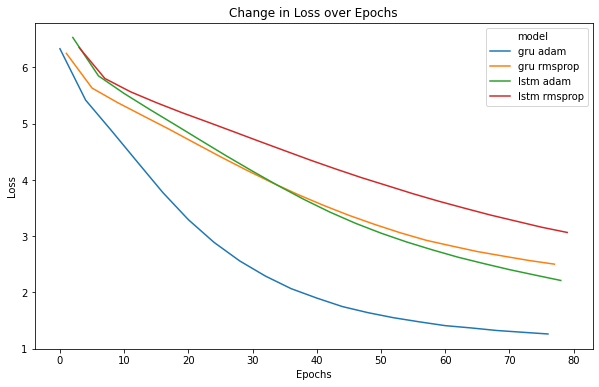

In [137]:
melted = histories_df.melt(id_vars=['optimizer', 'rnn_type', 'model'], value_name='loss')
plt.figure(figsize=(10,6))
sns.lineplot(y='loss', x=melted.index, data=melted, hue='model')
plt.title('Change in Loss over Epochs')
plt.xlabel(xlabel='Epochs')
plt.ylabel(ylabel='Loss')

## Postmortem
After completing this project, a few things would be done differently.
1. The generation function clears states, then reuses text to generate new text at the end of each line. I would edit this function to simply keep generating, and generate a newline and a rhyme, but KEEP GOING, and retain the latent cell states.
2. I would train the dataset on a much larger corpus to see if it had any significant improvement on the english readability.
3. I would love to find a way to work on the phoneme level rather than the word level. This would get Rap Bot one step closer to being able to create audio raps.


In [138]:
for i in range(10):
  start = random.sample(vocab, 1)[0]
  example_rap = make_song(model, START, num_total_lines=8)
  print(reverse_song(example_rap))


are you are parked up in park view nin drummin ac
out paper and bikes i got the stove be
hot bars you just need to usa
get some money today today
if i want you back i 'm sorry tonight tonight brain
oneul bame dorawajwoyo dorawajwoyo oh oh came
oh oh oh oh oh uhu yeah uhu uh uh text
uh uh aye squad prepare ayo next

been repossessed face down trash begets trash we know trash key
we know clean do n't last never last when we we
load trash we upload trash mama a lot do n't get ki
ready on it when i m here she
's my new bugatti a alive
miles and runnin my crew my crew they ho live
now bring gettin work put 'em in the text
dirt semi gon squirt damn he spoke creatin next

it to my last dollar on it holla like i m round
always keep a secret dude we 'll be lost and found found
this a route do what and nah i 'm came
fucking on these bitches runnin caught my on chain
fourth street a dollar pot boy semi
like i 'm finally lucid the chain out the many
things that why you drive it real text
niggas b